In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
growth = pd.read_excel("compras_internet.xlsx")
gdp2 = pd.read_csv("gdp_filtrado.csv")
pob2 = pd.read_csv("poblacion_seleccionada.csv")

### Se subieron los "pob2" y "gdp2" filtrados, ya que os originales eran archivos mayores a 2GB.

Se deben filtrar los países de Q3 de GDP per cápita, seleccionando solamente los países de los que tenemos información acerca de su crecimiento de compras en internet.

In [3]:
growth.drop(growth[growth["Country"]=="Czechia"].index, axis=0, inplace=True)

In [4]:
gdp2.drop(labels=["Unnamed: 0","Indicator Name","Indicator Code","Country Code"],axis=1,inplace=True)
index_drop_gdp = [index for index in gdp2["Country Name"].index if gdp2["Country Name"][index] not in list(growth["Country"])]
gdp2.drop(index_drop_gdp, axis=0, inplace=True)

In [5]:
pob2.drop(["Unnamed: 0","Country Code","Indicator Name"],axis=1, inplace=True)
index_drop_pob = [index for index in pob2["Country Name"].index if pob2["Country Name"][index] not in list(growth["Country"])]
pob2.drop(index_drop_pob, axis=0, inplace=True)

In [6]:
gr_cols = [int(value) for value in list(growth.columns[1:])]
growth.columns = [growth.columns[0]] + gr_cols

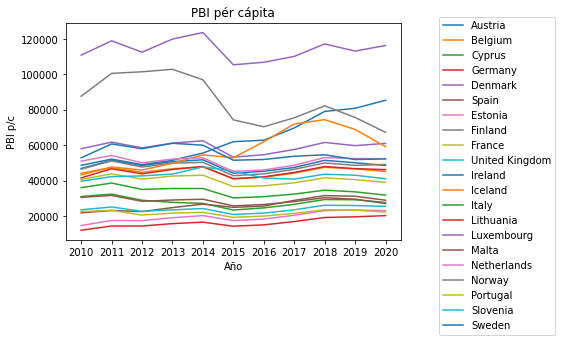

In [7]:
for country in range(len(gdp2)):
    plt.plot(gdp2.iloc[country][1:],label=gdp2.iloc[country]["Country Name"])
    plt.xlabel("Año")
    plt.ylabel("PBI p/c")
    plt.title("PBI pér cápita")
    plt.legend(bbox_to_anchor=(1.1, 1.05))

### Se aprecia una leve tendencia positiva en el PBI per cápita en la mayoria de los países de Europa seleccionados.

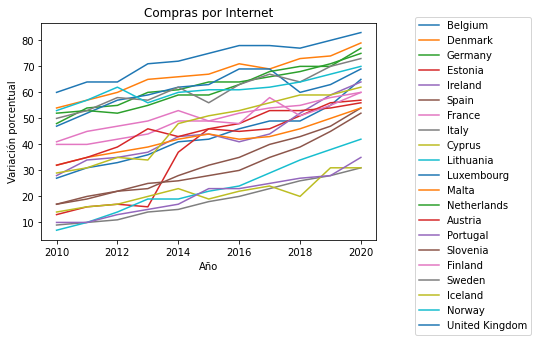

In [8]:
for country in range(len(growth)):
    plt.plot(growth.iloc[country][1:],label=growth.iloc[country]["Country"])
    plt.xlabel("Año")
    plt.ylabel("Variación porcentual")
    plt.title("Compras por Internet")
    plt.legend(bbox_to_anchor=(1.1, 1.05))

### Vemos una tendencia definida de todos los países seleccionados, en crecimiento, de las compras por Internet.

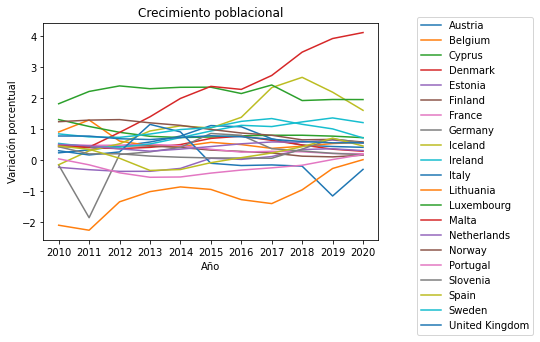

In [9]:
for country in range(len(pob2)):
    plt.plot(pob2.iloc[country][1:],label=pob2.iloc[country]["Country Name"])
    plt.xlabel("Año")
    plt.ylabel("Variación porcentual")
    plt.title("Crecimiento poblacional")
    plt.legend(bbox_to_anchor=(1.1, 1.05))

### Se distinguen algunos países con tendencia positiva, pero una cantidad notable con una tendencia estable, con un crecimiento o decrecimiento muy bajo.

In [10]:
gdp3 = pd.melt(gdp2, id_vars = ["Country Name"], var_name="year", value_name="GDP/c")
growth2 = pd.melt(growth, id_vars = ["Country"], var_name="year", value_name="Crec. compras")
pob3 = pd.melt(pob2, id_vars = ["Country Name"], var_name="year", value_name="Crec. poblacional")

In [11]:
gdp3 = gdp3.sort_values(["Country Name","year"])
pob3 = pob3.sort_values(["Country Name","year"])
growth2 = growth2.sort_values(["Country","year"])

In [12]:
growth2.shape, gdp3.shape, pob3.shape

((231, 3), (231, 3), (231, 3))

In [13]:
growth2["Crec. poblacional"] = pob3["Crec. poblacional"]
growth2["GDP/c"] = gdp3["GDP/c"]

In [14]:
growth2.head(5)

,Country,year,Crec. compras,Crec. poblacional,GDP/c
13,Austria,2010,32,0.491183,11987.50841
34,Austria,2011,35,0.423701,14376.94786
55,Austria,2012,39,0.899209,14367.70942
76,Austria,2013,46,1.404050,15729.65247
97,Austria,2014,43,1.996754,16551.01820


In [15]:
df_model = growth2.copy()

In [16]:
df_model.head(10)

,Country,year,Crec. compras,Crec. poblacional,GDP/c
13,Austria,2010,32,0.491183,11987.50841
34,Austria,2011,35,0.423701,14376.94786
55,Austria,2012,39,0.899209,14367.70942
76,Austria,2013,46,1.404050,15729.65247
97,Austria,2014,43,1.996754,16551.01820
118,Austria,2015,46,2.386395,14263.96458
139,Austria,2016,48,2.288615,15008.31324
160,Austria,2017,53,2.738663,16885.40739
181,Austria,2018,53,3.491955,19186.18128
202,Austria,2019,54,3.931356,19575.76848


## Creación de modelo predictivo: Regresión lineal
### Buscamos los scores para cada país, con tal de encontrar los países que podamos predecir con mayor exactitud, las variables dependientes, para el año que queramos.

In [17]:
def get_score(df,indep,dep):
    scores=[]
    
    for country in df["Country"].value_counts().index:
        x = df[df["Country"]==country][[indep]].values
        y = df[df["Country"]==country][dep]
        
        regr = sklearn.linear_model.LinearRegression()
        model = regr.fit(x,y)
        score = regr.score(x, y)
        scores.append(score)
    
    dic_score = dict(zip(df["Country"].value_counts().index,scores))
    
    
    return dic_score

In [18]:
pred_score = get_score(df_model,"year",["Crec. poblacional","Crec. compras","GDP/c"])
pred_score

{'Austria': 0.9080542348540547,
 'Lithuania': 0.622621558278465,
 'Sweden': 0.5395791155361117,
 'Spain': 0.6813260142778658,
 'Slovenia': 0.902637522123238,
 'Portugal': 0.46097597778996313,
 'Norway': 0.3702821787547849,
 'Netherlands': 0.47102880164552835,
 'Malta': 0.7734316089876584,
 'Luxembourg': 0.6703794133224311,
 'Italy': 0.39798864802202094,
 'Belgium': 0.3332309789107541,
 'Ireland': 0.579000097227253,
 'Iceland': 0.36106394780978573,
 'Germany': 0.5419036751402398,
 'France': 0.8807301239795146,
 'Finland': 0.2903689723603139,
 'Estonia': 0.33640391262980157,
 'Denmark': 0.43880979868206166,
 'Cyprus': 0.5753307021238905,
 'United Kingdom': 0.611608042781886}

In [19]:
valores = np.array(list(pred_score.values()))

In [20]:
index_valores = []
for index,value in enumerate(valores):
    if value > np.median(valores):
        index_valores.append(index)

In [21]:
seleccion = [pais for index,pais in enumerate(list(pred_score.keys())) if index in index_valores]

In [22]:
seleccion #Países con score mayor a la mediana

['Austria',
 'Lithuania',
 'Spain',
 'Slovenia',
 'Malta',
 'Luxembourg',
 'Ireland',
 'France',
 'Cyprus',
 'United Kingdom']

### Con los países seleccionados, predeciremos el crecimiento de las compras por internet y evaluaremos dónde será más rentable colocar 3 centros de distribución

In [23]:
def get_pred(df,indep,dep,countries,year):
    preds = []
    crec_pob = []
    crec_com = []
    gdp_c = []
    years = np.full(shape=len(countries),fill_value=year)

    for index,country in enumerate(countries):
        x = df[df["Country"]==country][[indep]].values.reshape(-1,1)
        y = df[df["Country"]==country][dep]
        
        regr = sklearn.linear_model.LinearRegression()
        model = regr.fit(x,y)
        score = regr.score(x, y)
        pred = regr.predict([[year]])
        preds.append(pred)
        
        crec_pob.append(preds[index][0][0])
        crec_com.append(preds[index][0][1])
        gdp_c.append(preds[index][0][2])
        
    df = pd.DataFrame({"Country":countries,
                       "year":years,
                       "Crec. poblacional":crec_pob,
                       "Crec. compras":crec_com,
                       "GDP/c":gdp_c})
        
    return df

In [24]:
final = get_pred(df_model,"year",["Crec. poblacional","Crec. compras","GDP/c"],seleccion,2030)

In [25]:
final

,Country,year,Crec. poblacional,Crec. compras,GDP/c
0,Austria,2030,8.052579,80.954545,26729.998182
1,Lithuania,2030,2.383978,74.181818,43031.309400
2,Spain,2030,-0.290534,87.409091,25430.104375
3,Slovenia,2030,-0.215764,78.545455,40288.111350
4,Malta,2030,1.402735,70.136364,98580.349993
5,Luxembourg,2030,-1.755623,86.818182,122368.175628
6,Ireland,2030,1.172161,90.500000,59282.609610
7,France,2030,-0.142866,81.272727,30871.425702
8,Cyprus,2030,4.802048,43.500000,35964.983513
9,United Kingdom,2030,0.395251,105.363636,45651.634322


### Se realizó una selección final por dos criterios:
#### PBI per cápita mayor a la mediana
#### Crecimiento de compras mayor a la mediana

### Los países elegidos para colocar los centros de distribución son los siguientes:

In [26]:
final[(final["Crec. compras"]>np.percentile(final["Crec. compras"],50)) & (final["GDP/c"]>np.percentile(final["GDP/c"],50))]

,Country,year,Crec. poblacional,Crec. compras,GDP/c
5,Luxembourg,2030,-1.755623,86.818182,122368.175628
6,Ireland,2030,1.172161,90.500000,59282.609610
9,United Kingdom,2030,0.395251,105.363636,45651.634322
